# Detailed run

An example of a complete run of lephare with all stages required to estimate redshift. In contrast to the two first notebooks we are not using the high level *prepare* and *process* methods. Instead we are using the more fundamental *filter*, *sedtolib*, *mag_gal*, and *zphota* which more resembles a command line based run.

We show how to include new filters from the Spanish Virtual Observatory [(SVO)](http://svo2.cab.inta-csic.es/theory/fps/).

Again this notebook uses the COSMOS2020 (Weaver et al. 2022) data as an example.

The notebook can be downloaded [here](https://github.com/lephare-photoz/lephare/blob/main/docs/notebooks/Detailed_run.ipynb).

In [1]:
import os
import lephare as lp
import numpy as np
from matplotlib import pylab as plt

%matplotlib inline

LEPHAREDIR is being set to the default cache directory:
/home/hallouin/.cache/lephare/data
More than 1Gb may be written there.
LEPHAREWORK is being set to the default cache directory:
/home/hallouin/.cache/lephare/work
Default work cache is already linked. 
This is linked to the run directory:
/home/hallouin/.cache/lephare/runs/20251013T115331


## Set up the parameters


As for the previous notebooks we are starting with the default COSMOS config that ships with the lephare Python code.

Modification of three keywords of the parameter file. 

In [2]:
# Default config from COSMOS
config = lp.default_cosmos_config.copy()

# You could also load this from a local text file:
# config=lp.keymap_to_string_dict(lp.read_config("your_own.para"))
# An example can be downloaded with curl
# !curl -s -o ./COSMOS.para https://raw.githubusercontent.com/lephare-photoz/lephare-data/refs/heads/main/examples/COSMOS.para
# config = lp.read_config("./COSMOS.para")

# update keywords
config.update(
    {
        # Verbose must be NO in the notebook.
        "VERBOSE": "NO",
        # this line reduced the zgrid density from the default to make the notebook run faster.
        # Comment this out for better science results
        "Z_STEP": "0.04,0.,6.",
    }
)

Then we get the auxiliary files required to run the notebook for the documentation. If you have cloned the full auxiliary data repository you do not need to run this.

In [3]:
lp.data_retrieval.get_auxiliary_data(
    keymap=config,
    additional_files=["examples/COSMOS.in", "examples/config_svo_filters.yml", "examples/output.para"],
)

Registry file downloaded and saved as data_registry.txt.
Checking/downloading 445 files...
445 completed.
All files downloaded successfully and are non-empty.
Checking/downloading 3 files...
3 completed.
All files downloaded successfully and are non-empty.


## Create filter library

Read the filter names to be used in COSMOS.para and generate the filter file

First, you can use the standard method with the list of filters in the parameter file. The filters are store in the LEPHAREDIR/filt directory. You can pass either the config file or the keymap as argument

### Getting new filters

Each filter requires a filter response curve. This is a table of wavelength values in Angstrom and filter transmission in arbitrary units. In this example we get the filters we need from the [SVO](http://svo2.cab.inta-csic.es/theory/fps/). We could have also used the filters that are available in [$LEPHAREDIR/filt](https://github.com/lephare-photoz/lephare-data/tree/main/filt). Or one could also use local files.

In [4]:
# This would get the filters from the config file and local LEPHAREDIR/filt location.
# Later we see how to do the same from the SVO.
filterRunner = lp.Filter(config_keymap=lp.all_types_to_keymap(config))
filterLib = filterRunner.run()

# NAME                        IDENT      Lbda_mean Lbeff(Vega)       FWHM     AB-cor    TG-cor      VEGA M_sun(AB)   CALIB      Lb_eff    Fac_corr
u_cfht.lowres                 1             0.3844      0.3908      0.0538    0.3150   -0.3891  -20.6345    6.0327       0      0.3815      1.0000
u_new.pb                      2             0.3690      0.3750      0.0456    0.6195   -0.2745  -20.8527    6.3135       0      0.3668      1.0000
gHSC.pb                       3             0.4851      0.4760      0.1194   -0.0860   -0.2458  -20.7272    5.0764       0      0.4780      1.0000
rHSC.pb                       4             0.6241      0.6142      0.1539    0.1466    0.2580  -21.5143    4.6523       0      0.6178      1.0000
iHSC.pb                       5             0.7716      0.7637      0.1476    0.3942    0.6138  -22.2286    4.5323       0      0.7666      1.0000
zHSC.pb                       6             0.8915      0.8907      0.0768    0.5169    0.7625  -22.6733    4.5147    

It is also possible to pass all the necessary keywords as arguments to the constructor:

In [5]:
# the config keymap from a config file can also be added to the constructor's arguments, in which case the keywords
# will be overridden by the explicit keywords passed as arguments below.
filterRunner2 = lp.Filter(
    FILTER_REP=os.path.join(os.environ["LEPHAREDIR"], "filt"),
    FILTER_LIST="cosmos/u_cfht.lowres,cosmos/u_new.pb,hsc/gHSC.pb,hsc/rHSC.pb,\
                       hsc/iHSC.pb,hsc/zHSC.pb,hsc/yHSC.pb,vista/Y.lowres,vista/J.lowres,vista/H.lowres,\
                       vista/K.lowres,cosmos/IB427.lowres,cosmos/IB464.lowres,cosmos/IB484.lowres,\
                       cosmos/IB505.lowres,cosmos/IB527.lowres,cosmos/IB574.lowres,cosmos/IB624.lowres,\
                       cosmos/IB679.lowres,cosmos/IB709.lowres,cosmos/IB738.lowres,cosmos/IB767.lowres,\
                       cosmos/IB827.lowres,cosmos/NB711.lowres,cosmos/NB816.lowres,vista/NB118.lowres,\
                       cosmos/irac_ch1.lowres,cosmos/irac_ch2.lowres,cosmos/irac_ch3.lowres,cosmos/irac_ch4.lowres",
    TRANS_TYPE=1,
    FILTER_CALIB="0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1",
    FILTER_FILE="filter_cosmos",
)
filterLib2 = filterRunner2.run()

# NAME                        IDENT      Lbda_mean Lbeff(Vega)       FWHM     AB-cor    TG-cor      VEGA M_sun(AB)   CALIB      Lb_eff    Fac_corr
u_cfht.lowres                 1             0.3844      0.3908      0.0538    0.3150   -0.3891  -20.6345    6.0327       0      0.3815      1.0000
u_new.pb                      2             0.3690      0.3750      0.0456    0.6195   -0.2745  -20.8527    6.3135       0      0.3668      1.0000
gHSC.pb                       3             0.4851      0.4760      0.1194   -0.0860   -0.2458  -20.7272    5.0764       0      0.4780      1.0000
rHSC.pb                       4             0.6241      0.6142      0.1539    0.1466    0.2580  -21.5143    4.6523       0      0.6178      1.0000
iHSC.pb                       5             0.7716      0.7637      0.1476    0.3942    0.6138  -22.2286    4.5323       0      0.7666      1.0000
zHSC.pb                       6             0.8915      0.8907      0.0768    0.5169    0.7625  -22.6733    4.5147    

Second, you can use the filterSvc helper class to gain more freedom. This class allows to retrieve the list of filt objetcs, independently of writing them on file.

In [6]:
filterLib = lp.FilterSvc.from_keymap(lp.all_types_to_keymap(config))
filter_output = os.path.join(os.environ["LEPHAREWORK"], "filt", config["FILTER_FILE"])
lp.write_output_filter(filter_output + ".dat", filter_output + ".doc", filterLib)

# NAME                        IDENT      Lbda_mean Lbeff(Vega)       FWHM     AB-cor    TG-cor      VEGA M_sun(AB)   CALIB      Lb_eff    Fac_corr
u_cfht.lowres                 1             0.3844      0.3908      0.0538    0.3150   -0.3891  -20.6345    6.0327       0      0.3815      1.0000
u_new.pb                      2             0.3690      0.3750      0.0456    0.6195   -0.2745  -20.8527    6.3135       0      0.3668      1.0000
gHSC.pb                       3             0.4851      0.4760      0.1194   -0.0860   -0.2458  -20.7272    5.0764       0      0.4780      1.0000
rHSC.pb                       4             0.6241      0.6142      0.1539    0.1466    0.2580  -21.5143    4.6523       0      0.6178      1.0000
iHSC.pb                       5             0.7716      0.7637      0.1476    0.3942    0.6138  -22.2286    4.5323       0      0.7666      1.0000
zHSC.pb                       6             0.8915      0.8907      0.0768    0.5169    0.7625  -22.6733    4.5147    

It also allows to load the filters from a yaml file, with the possibility to query the SVO service for filters

In [7]:
!ls $LEPHAREDIR/examples/

AGE_BC03COMB.dat	COSMOS.in	  filter_extinc.dat  README_full
AGE_MASATO_BC03.dat	COSMOS.in.header  HERSCHEL.para      README_short
AGN_MOD.list		COSMOS_MOD.list   magabs.header      spec.py
BC03COMB_MOD.list	COSMOS.para	  MIPS.in	     STAR_MOD_ALL.list
color.py		DALE.list	  MIPS.in.head	     UVISTA_MOD.list
config_svo_filters.yml	figuresLPP.py	  output_mass.para   WORK
config.yml		figuresLPZ.py	  output.para


In [8]:
# We use an example yaml file to retrieve the filter names used by the SVO
filterLibSVO = lp.FilterSvc.from_yaml(f"{lp.LEPHAREDIR}/examples/config_svo_filters.yml")
filter_output = os.path.join(os.environ["LEPHAREWORK"], "filt", config["FILTER_FILE"])
lp.write_output_filter(filter_output + "_svo.dat", filter_output + "_svo.doc", filterLibSVO)

# NAME                        IDENT      Lbda_mean Lbeff(Vega)       FWHM     AB-cor    TG-cor      VEGA M_sun(AB)   CALIB      Lb_eff    Fac_corr
MegaCam.u_1                   2             0.3818      0.3884      0.0601    0.3478   -0.3793  -20.6542    6.0708       0      0.3793      1.0000
MegaCam.u                     3             0.3693      0.3753      0.0456    0.6143   -0.2762  -20.8493    6.3092       0      0.3671      1.0000
HSC.g                         4             0.4851      0.4760      0.1187   -0.0860   -0.2457  -20.7273    5.0764       0      0.4780      1.0000
HSC.r                         5             0.6265      0.6169      0.1496    0.1518    0.2660  -21.5284    4.6480       0      0.6203      1.0000
HSC.i                         6             0.7769      0.7683      0.1560    0.4032    0.6245  -22.2518    4.5314       0      0.7715      1.0000
HSC.z                         7             0.8918      0.8909      0.0774    0.5168    0.7624  -22.6737    4.5146    

Plot the filters. We can see slight differences between those on the SVO and in the lepahre database.

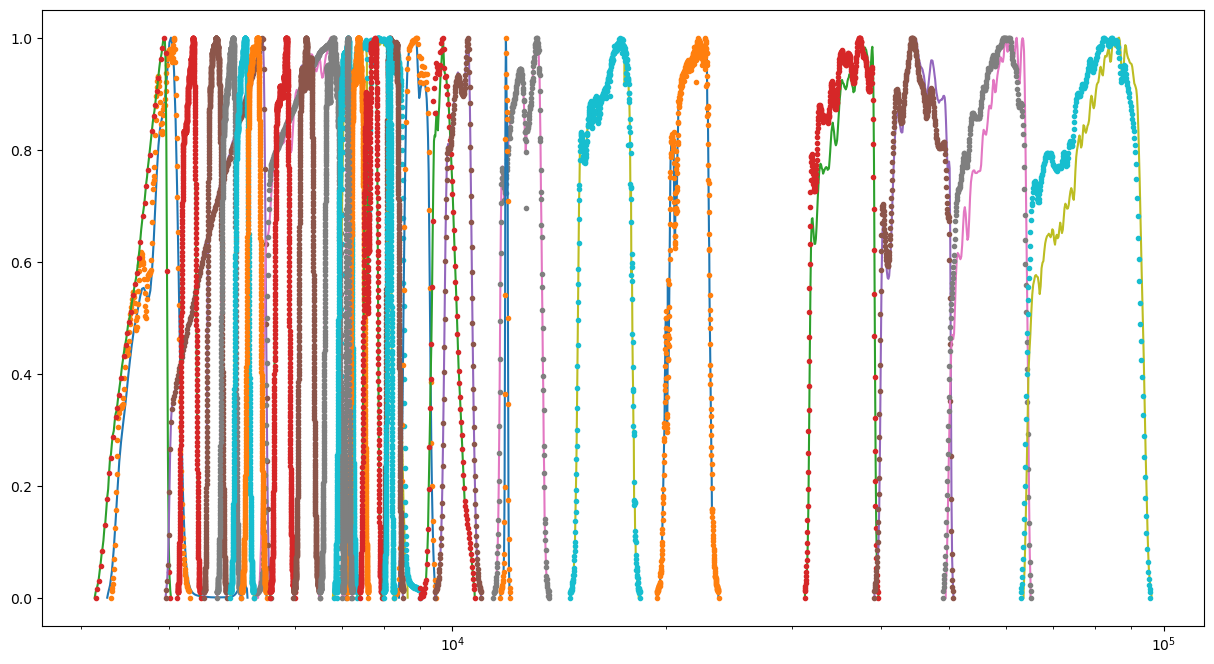

In [9]:
fig = plt.figure(figsize=(15, 8))
for f, fsvo in zip(filterLib, filterLibSVO):
    d = f.data()
    plt.semilogx(d[0], d[1] / d[1].max())
    dsvo = fsvo.data()
    plt.semilogx(dsvo[0], dsvo[1] / dsvo[1].max(), ".")

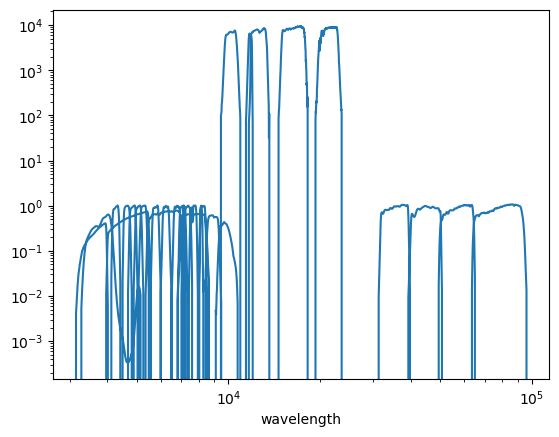

In [10]:
# filter_output = os.path.join(os.environ["LEPHAREWORK"],"filt", filterLib.keymap['FILTER_FILE'] + ".dat")
# This figure shows that the filters have differing normalisation which has no impact on the fitting process.
filters = np.loadtxt(
    filter_output + ".dat", dtype={"names": ("lamb", "val", "bid"), "formats": (float, float, int)}
)
plt.loglog(filters["lamb"], filters["val"])
plt.xlabel("wavelength");

## Create SED library

SED objects represent SED templates belonging to one of the three possible classes "STAR", "QSO" (for AGN type of objects), and "GAL" for galaxies. SED templates available with LePhare can be found under the `sed` directory. 

In [11]:
sedlib = lp.Sedtolib(config_keymap=lp.all_types_to_keymap(config))

In [12]:
sedlib.run(typ="STAR", star_sed="$LEPHAREDIR/sed/STAR/STAR_MOD_ALL.list")

#######################################
# It s translating SEDs to binary library #
# with the following options :           
# Config file     : 
# Library type     : STAR
# STAR_SED    :/home/hallouin/.cache/lephare/data/sed/STAR/STAR_MOD_ALL.list
# STAR_LIB    :LIB_STAR
# STAR_LIB doc:/home/hallouin/.cache/lephare/work/lib_bin/LIB_STAR.doc
# STAR_FSCALE :0.0000
#######################################
Number of SED in the list 254


In [13]:
sedlib.run(typ="QSO", qso_sed="$LEPHAREDIR/sed/QSO/SALVATO09/AGN_MOD.list", gal_lib="LIB_QSO")

#######################################
# It s translating SEDs to binary library #
# with the following options :           
# Config file     : 
# Library type     : QSO
# QSO_SED    :/home/hallouin/.cache/lephare/data/sed/QSO/SALVATO09/AGN_MOD.list
# QSO_LIB    :LIB_QSO
# QSO_LIB doc:/home/hallouin/.cache/lephare/work/lib_bin/LIB_QSO.doc
# QSO_FSCALE :1.0000
#######################################
Number of SED in the list 30


In [14]:
sedlib.run(typ="GAL", gal_sed="$LEPHAREDIR/sed/GAL/COSMOS_SED/COSMOS_MOD.list", gal_lib="LIB_GAL")

#######################################
# It s translating SEDs to binary library #
# with the following options :           
# Config file     : 
# Library type     : GAL
# GAL_SED    :/home/hallouin/.cache/lephare/data/sed/GAL/COSMOS_SED/COSMOS_MOD.list
# GAL_LIB    :LIB_GAL
# GAL_LIB doc:/home/hallouin/.cache/lephare/work/lib_bin/LIB_GAL.doc
# GAL_LIB phys:/home/hallouin/.cache/lephare/work/lib_bin/LIB_GAL.phys
# SEL_AGE    :none
# GAL_FSCALE :1.0000
# AGE_RANGE   0.0000 15000000000.0000
#######################################
Number of SED in the list 31


## Create a magnitude library

Use the SED library to create a magnitude library

In [15]:
maglib = lp.MagGal(config_keymap=lp.all_types_to_keymap(config))

In [16]:
maglib.run(
    typ="STAR",
    lib_ascii="YES",
    star_lib_out="STAR_COSMOS",
    extinc_law="SB_calzetti.dat",
    mod_extinc="0,0",
)

#######################################
# It s computing the SYNTHETIC MAGNITUDES #
# For Gal/QSO libraries with these OPTIONS #
# with the following options :           
# Config file     : 
# Filter file     : filter_cosmos
# Magnitude type     : AB
# COSMOLOGY   :70.0000,0.3000,0.7000
# STAR_LIB_IN    :/home/hallouin/.cache/lephare/work/lib_bin/LIB_STAR(.doc & .bin)
# STAR_LIB_OUT   :/home/hallouin/.cache/lephare/work/lib_mag/STAR_COSMOS(.doc & .bin)
# LIB_ASCII   YES
# CREATION_DATE Fri Oct 24 16:08:05 2025
#############################################


In [17]:
maglib.run(
    typ="QSO",
    lib_ascii="YES",
    mod_extinc="0,1000",
    eb_v="0.,0.1,0.2,0.3",
    extinc_law="SB_calzetti.dat",
    qso_lib_in="LIB_QSO",
    qso_lib_out="QSO_COSMOS",
)

#######################################
# It s computing the SYNTHETIC MAGNITUDES #
# For Gal/QSO libraries with these OPTIONS #
# with the following options :           
# Config file     : 
# Filter file     : filter_cosmos
# Magnitude type     : AB
# QSO_LIB_IN    :/home/hallouin/.cache/lephare/work/lib_bin/LIB_QSO(.doc & .bin)
# QSO_LIB_OUT   :/home/hallouin/.cache/lephare/work/lib_mag/QSO_COSMOS(.doc & .bin)
# Z_STEP   :0.0400 0.0000 6.0000
# COSMOLOGY   :70.0000,0.3000,0.7000
# EXTINC_LAW   :SB_calzetti.dat 
# MOD_EXTINC   :0 1000 
# EB_V   :0.0000 0.1000 0.2000 0.3000 # LIB_ASCII   YES
# CREATION_DATE Fri Oct 24 16:08:05 2025
#############################################


In [18]:
maglib.run(
    typ="GAL",
    lib_ascii="YES",
    gal_lib_in="LIB_GAL",
    gal_lib_out="GAL_COSMOS",
    mod_extinc="18,26,26,33,26,33,26,33",
    extinc_law="SMC_prevot.dat,SB_calzetti.dat,SB_calzetti_bump1.dat,SB_calzetti_bump2.dat",
    em_lines="EMP_UV",
    em_dispersion="0.5,0.75,1.,1.5,2.",
)

#######################################
# It s computing the SYNTHETIC MAGNITUDES #
# For Gal/QSO libraries with these OPTIONS #
# with the following options :           
# Config file     : 
# Filter file     : filter_cosmos
# Magnitude type     : AB
# GAL_LIB_IN    :/home/hallouin/.cache/lephare/work/lib_bin/LIB_GAL(.doc & .bin)
# GAL_LIB_OUT   :/home/hallouin/.cache/lephare/work/lib_mag/GAL_COSMOS(.doc & .bin)
# Z_STEP   :0.0400 0.0000 6.0000
# COSMOLOGY   :70.0000,0.3000,0.7000
# EXTINC_LAW   :SMC_prevot.dat SB_calzetti.dat SB_calzetti_bump1.dat SB_calzetti_bump2.dat 
# MOD_EXTINC   :18 26 26 33 26 33 26 33 
# EB_V   :0.0000 0.1000 0.2000 0.3000 
# EM_LINES   EMP_UV
# EM_DISPERSION   0.5000,0.7500,1.0000,1.5000,2.0000,
# LIB_ASCII   YES
# CREATION_DATE Fri Oct 24 16:08:07 2025
#############################################


## Run the photoz

Read the parameter file and store the keywords. Example with the modification of three keywords of the parameter file. Verbose must be NO in the notebook.

In [19]:
# These are the names created above with the argument gal_lib_out
config.update(
    {
        "ZPHOTLIB": "GAL_COSMOS,STAR_COSMOS,QSO_COSMOS",
        "SPEC_OUT": "save_spec",
        "AUTO_ADAPT": "YES",
        # "APPLY_SYSSHIFT": "0.049,-0.013,-0.055,-0.065,-0.042,-0.044,-0.065,-0.0156,-0.002,0.052,-0.006,0.071,0.055,0.036,0.036,0.054,0.088,0.019,-0.154,0.040,0.044,0.060,0.045,0.022,0.062,0.033,0.015,0.012,0.0,0.0]"
        "CHI2_OUT": "YES"
    }
)

Instantiate a lephare.PhotoZ object which will manage the computation of photometric redshifts for all sources. It is instantiated based on all the config parameters. 



In [20]:
photz = lp.PhotoZ(lp.all_types_to_keymap(config))

####################################### 
# PHOTOMETRIC REDSHIFT with OPTIONS   # 
# Config file            : 
# CAT_IN                 : change_me_to_output_filename_required.ascii
# CAT_OUT                : zphot.out
# CAT_LINES              : 0 1000000000
# PARA_OUT               : /home/hallouin/.cache/lephare/data/examples/output.para
# INP_TYPE               : F
# CAT_FMT[0:MEME 1:MMEE] : 0
# CAT_MAG                : AB
# ZPHOTLIB               : GAL_COSMOS STAR_COSMOS QSO_COSMOS 
# FIR_LIB                : 
# FIR_LMIN               : 7.000000
# FIR_CONT               : -1.000000
# FIR_SCALE              : -1.000000
# FIR_FREESCALE          : YES
# FIR_SUBSTELLAR         : NO
# ERR_SCALE              : 0.020000 0.020000 0.020000 0.020000 0.020000 0.020000 0.020000 0.050000 0.050000 0.050000 0.050000 0.020000 0.020000 0.020000 0.020000 0.020000 0.020000 0.020000 0.020000 0.020000 0.020000 0.020000 0.020000 0.050000 0.050000 0.050000 0.050000 0.100000 0.200000 0.300000 
# ERR_FACTOR

Read the input file with the following information: id, flux and associated uncertainties in all bands, a context indicating which bands to use in the fit (0 indicates all bands), and a spectrocopic redshift if it exists. 

In [21]:
cat = np.loadtxt(f"{lp.LEPHAREDIR}/examples/COSMOS.in")
id = cat[:, 0]
fluxes = cat[:, 1:60:2]
efluxes = cat[:, 2:61:2]
context = cat[:, 61]
zspec = cat[:, 62]
print("Check format with context and zspec :", context, zspec)

Check format with context and zspec : [0. 0. 0. ... 0. 0. 0.] [4.839  1.166  0.1649 ... 0.214  0.3053 0.3448]


Create a list of sources with a spec-z. Use for the zero-point training or any validation run.


In [22]:
srclist = []
# Here, limited to the 1000 first sources.
n_obj = 100
zspec_mask = np.logical_and(zspec > 0.01, zspec < 6)
# We are running on the last n_obj objects to use a different set of objects to perform
# zero-point correction to the test objects
for i in np.where(zspec_mask)[0][-n_obj:]:
    # Each element of the list is an instance of the lephare.onesource class.
    # This encapsulates all the information for a given source.
    oneObj = lp.onesource(i, photz.gridz)
    oneObj.readsource(str(id[i]), fluxes[i, :], efluxes[i, :], int(context[i]), zspec[i], " ")
    # lephare.PhotoZ passes the configuration parameters to each source.
    photz.prep_data(oneObj)
    srclist.append(oneObj)
print("Sources with a spec-z: ", len(srclist))

Sources with a spec-z:  100


Derive the zero-points offsets. This corresponds to the median difference between apparent and observed magnitude in each filter. It is stored in the list, a0, which is later passed to the lephare.PhotoZ.run_photoz method. If AUTO_ADAPT is NO, values will be set at 0. If APPLY_SYSSHIFT is defined, that's the values which will be used for a0.

In [23]:
a0 = photz.compute_offsets(srclist)
offsets = ",".join(np.array(a0).astype(str))
offsets = "# Offsets to be added to the modeled magnitudes: " + offsets + "\n"
print(offsets)

 Done with iteration 1 and converge 0# Offsets to be added to the modeled magnitudes: 0.10751512239554017,-0.013751160173164578,-0.04198025243697501,-0.11697590956252668,-0.09595743234742926,-0.08431394082082377,-0.10276348890739584,-0.044068619642605,-0.039664628886509234,0.017605114933900268,-0.07656523116365577,0.09369064997226317,0.05348684467240261,0.05345134781697425,0.06153858677055268,0.03245630622697604,0.06847885499805528,-0.02096930716481893,-0.1740966741636818,-0.015910269608834682,0.014805848378379949,0.03900683231785962,0.013014177355216816,-0.04133049813958323,0.040922473395568204,0.011079604090248552,-0.0745761365923947,-0.09542690832294554,0.0,0.0


 Done with iteration 2 and converge 0
 Done with iteration 3 and converge 1


Create the list of sources for which we want a photo-z. 

In [24]:
photozlist = []
for i in range(n_obj):
    oneObj = lp.onesource(i, photz.gridz)
    oneObj.readsource(str(id[i]), fluxes[i, :], efluxes[i, :], int(context[i]), zspec[i], " ")
    photz.prep_data(oneObj)
    photozlist.append(oneObj)
print("Number of sources to be analysed: ", len(srclist))

Number of sources to be analysed:  100


Run the photoz. We pass the values of the zero point calibration calculated above

In [25]:
photz.run_photoz(photozlist, a0)

[run_photoz] Source Id=1.0 | n_SEDs=102934 | sum(chi2)=882026880763.1707 | min=37.8561 | max=1000000000.0000
[run_photoz] Source Id=2.0 | n_SEDs=102934 | sum(chi2)=37923118464334.5859 | min=24.8699 | max=1000000000.0000
[run_photoz] Source Id=3.0 | n_SEDs=102934 | sum(chi2)=74985436347802.1406 | min=55.5730 | max=1000000000.0000
[run_photoz] Source Id=4.0 | n_SEDs=102934 | sum(chi2)=895013413593.0988 | min=21.2415 | max=1000000000.0000
[run_photoz] Source Id=5.0 | n_SEDs=102934 | sum(chi2)=953014719801.6705 | min=33.4594 | max=1000000000.0000
[run_photoz] Source Id=6.0 | n_SEDs=102934 | sum(chi2)=579200132127.6167 | min=14.6505 | max=1000000000.0000
[run_photoz] Source Id=7.0 | n_SEDs=102934 | sum(chi2)=719074433575.2843 | min=8.7731 | max=1000000000.0000
[run_photoz] Source Id=8.0 | n_SEDs=102934 | sum(chi2)=1010008950109.9492 | min=15.7423 | max=1000000000.0000
[run_photoz] Source Id=9.0 | n_SEDs=102934 | sum(chi2)=45586211329782.8203 | min=26.3482 | max=1000000000.0000
[run_photoz] 

### Save the parameters that have been used

For capturing the parameters that were used in a given run it is useful to save the updated config to file. Be careful as this will not capture the overrides that were sent directly to the lephare.MagGal.run method which impact the outputs.

In [ ]:
# we can write the config to a file to keep a record
lp.write_para_config(lp.all_types_to_keymap(config), "./config_file.para")
# One can also save it as a yaml file if you prefer
lp.write_yaml_config(lp.all_types_to_keymap(config), "./config_file.yaml")

## Create output in fits


In [26]:
t = photz.build_output_tables(photozlist[:n_obj], para_out=None, filename="outputphotoz.fits")

In [27]:
t[:5]

IDENT,Z_BEST,Z_BEST68_LOW,Z_BEST68_HIGH,Z_MED,Z_MED68_LOW,Z_MED68_HIGH,CHI_BEST,MOD_BEST,EXTLAW_BEST,EBV_BEST,Z_SEC,CHI_SEC,MOD_SEC,EBV_SEC,ZQ_BEST,CHI_QSO,MOD_QSO,MOD_STAR,CHI_STAR,MAG_OBS(),ERR_MAG_OBS(),K_COR(),MAG_ABS(),EMAG_ABS(),MABS_FILT(),SCALE_BEST,NBAND_USED,CONTEXT,ZSPEC,AGE_BEST,AGE_INF,AGE_MED,AGE_SUP,LDUST_BEST,LDUST_INF,LDUST_MED,LDUST_SUP,LUM_TIR_BEST,LUM_TIR_INF,LUM_TIR_MED,LUM_TIR_SUP,MASS_BEST,MASS_INF,MASS_MED,MASS_SUP,SFR_BEST,SFR_INF,SFR_MED,SFR_SUP,SSFR_BEST,SSFR_INF,SSFR_MED,SSFR_SUP,COL1_INF,COL1_MED,COL1_SUP,COL2_INF,COL2_MED,COL2_SUP,LUM_NUV_BEST,LUM_R_BEST,LUM_K_BEST,MAG_PRED(),STRING_INPUT,BAY_ZG
str5,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,float64,float64[30],float64[30],float64[30],float64[30],float64[30],float64[30],float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64[0],str1,float64[151]
1.0,4.853080492769338,4.838848085700959,4.845507024036549,4.8410161351259005,4.813133637211075,4.86821613657054,37.856100061678234,29,1.0,0.0,-99.9,-99.0,-99,-99.0,4.776280077096317,98.02550531486065,29,204,135.15301956804538,1000.0 .. 1000.0,1000.0 .. 1000.0,966.2305682130575 .. -2.2239310754060853,-20.483102576843944 .. -20.052866603827624,-1.0 .. -1.0,-1.0 .. -1.0,227.26284633101358,27,0,4.839,-999.0,-99.9,-99.9,-99.9,-999.0,-99.9,-99.9,-99.9,-999.0,-99.9,-99.9,-99.9,-999.0,-99.9,-99.9,-99.9,-999.0,-99.9,-99.9,-99.9,-999.0,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,9.554660943001327,9.166953032216401,8.13254118734207,,,0.0 .. 2.4920965371441736e-42
2.0,1.189388935805745,1.1959067802063315,1.2012554603668033,1.1700265628526187,1.0693263414680285,1.217476509737414,30.093595647762406,18,1.0,0.1,-99.9,-99.0,-99,-99.0,0.966661396045455,24.869880911842053,19,136,584.518738119964,24.7160136546355 .. 1000.0,0.0964327877384378 .. 1000.0,0.9639373494376868 .. -0.050144543942796965,-20.90210516937807 .. -23.422198828996468,0.4075378180378362 .. 3.026369808293129,5.0 .. 10.0,558.9999110522548,27,0,1.166,-999.0,-99.9,-99.9,-99.9,-999.0,-99.9,-99.9,-99.9,-999.0,-99.9,-99.9,-99.9,-999.0,-99.9,-99.9,-99.9,-999.0,-99.9,-99.9,-99.9,-999.0,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,9.47625887700427,9.933577162219951,9.410834261790185,,,2.0568270949098572e-135 .. 0.0
3.0,0.1604570011662561,0.1595836914501862,0.16043577879533816,0.16,0.1327999997138977,0.1872000002861023,55.57302966725526,7,1.0,0.0,-99.9,-99.0,-99,-99.0,0.14921439461609912,121.01130963272658,9,98,875.937043312699,20.348301028072378 .. 1000.0,0.030183067850864845 .. 1000.0,0.6920535871141925 .. -0.40613677582154034,-19.780910626629048 .. -20.358916093879184,0.3861506934648933 .. 2.7198853554640348,2.0 .. 10.0,150.22397059551182,28,0,0.1649,-999.0,-99.9,-99.9,-99.9,-999.0,-99.9,-99.9,-99.9,-999.0,-99.9,-99.9,-99.9,-999.0,-99.9,-99.9,-99.9,-999.0,-99.9,-99.9,-99.9,-999.0,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,7.846166358859396,9.626577741958009,9.154315882962926,,,2.0236796113108527e-223 .. 0.0
4.0,5.654852228540542,5.634329965347776,5.678388134571853,5.452936926286467,5.291497486376177,5.6879022271308015,21.241473215194816,29,1.0,0.0,-99.9,-99.0,-99,-99.0,5.596200094324459,37.56644819766449,29,196,57.82406436425819,28.195532699302532 .. 1000.0,1.9744363436325476 .. 1000.0,965.841624090202 .. -2.393336073825246,-20.96710849677425 .. -20.536872523757932,-1.0 .. -1.0,-1.0 .. -1.0,354.9202752274656,28,0,5.742,-999.0,-99.9,-99.9,-99.9,-999.0,-99.9,-99.9,-99.9,-999.0,-99.9,-99.9,-99.9,-999.0,-99.9,-99.9,-99.9,-999.0,-99.9,-99.9,-99.9,-999.0,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,-99.9,9.74826331097345,9.360555400188524,8.326143555314193,,,0.0 .. 5.790862771906529e-13
5.0,0.866765115954973

Create all ascii files with the output of the run

In [ ]:
import time

photz.write_outputs(photozlist[:5], int(time.time()))

In [ ]:
# This created the output ascii file specified in the config CAT_OUT parameter
!ls -al zphot.out

Check the results broadly follow a 1-1 relation

In [ ]:
plt.plot([0, 6], [0, 6], c="r", alpha=0.5)
plt.scatter(t["ZSPEC"], t["Z_BEST"], s=3)
plt.xlabel("z spec")
plt.ylabel("z phot")

Make plots for individual sources with all the files listed in save_spec

In [ ]:
from os import listdir
from os.path import isfile, join

listname = [f for f in listdir("save_spec") if isfile(join("save_spec", f))]
# Lets just look at the top 10
for namefile in listname[:10]:
    lp.plotspec("save_spec/" + str(namefile))